In [304]:
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from pmdarima.arima import auto_arima
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller

# Part 1: Data Pre-Processing

In [378]:
# importing the file and removing extraneous columns
ng = pd.read_csv('ng-test.csv')
ng = ng[['Date', 'Supply (Bcf/day)', 'Demand (Bcf/day)', 'Inventory (Bcf)',
       'EDD', 'Price']]

In [379]:
ng

,Date,Supply (Bcf/day),Demand (Bcf/day),Inventory (Bcf),EDD,Price
0,1/31/2014,67.3,98.6,"1,898",33.9,4.60
1,2/28/2014,66.3,92.9,"1,152",31.9,5.86
2,3/31/2014,65.8,78.3,763,23.6,4.77
3,4/30/2014,67.1,59.4,993,13.0,4.61
4,5/31/2014,67.7,51.7,"1,490",8.3,4.56
...,...,...,...,...,...,...
94,11/30/2021,73.8,NaN,NaN,18.9,NaN
95,12/31/2021,73.9,NaN,NaN,27.5,NaN
96,1/31/2022,73.7,NaN,NaN,30.3,NaN
97,2/28/2022,73.6,NaN,NaN,27.5,NaN


In [380]:
ng.dtypes

Date                 object
Supply (Bcf/day)    float64
Demand (Bcf/day)    float64
Inventory (Bcf)      object
EDD                 float64
Price               float64
dtype: object

<b>The datatypes are not consistent!</b>

In [381]:
ng.columns = ['date','supply','demand','inventory','edd','price']
ng['date'] = pd.to_datetime(ng['date'], format = "%m/%d/%Y")
ng.set_index('date')
ng['inventory'] = ng[ng['inventory'].isnull() != True].inventory.str.strip().str.replace(',','').astype(float)
ng.dtypes

date         datetime64[ns]
supply              float64
demand              float64
inventory           float64
edd                 float64
price               float64
dtype: object

<b>Now we're good.</b>

# Part 2: Exploratory Data Analysis

In [382]:
ng.describe().round(2)

,supply,demand,inventory,edd,price
count,99.00,92.00,92.00,99.00,92.00
mean,72.88,72.79,2658.18,16.65,2.90
std,4.31,13.94,795.42,7.89,0.83
min,64.80,51.70,763.00,8.00,1.57
25%,69.45,61.30,2081.50,9.85,2.44
50%,72.60,69.45,2703.50,12.50,2.80
75%,76.05,82.60,3222.75,23.05,3.09
max,81.80,101.70,4037.00,34.00,5.86


<b>We were already aware that some variables were missing values from the prompt and from visualization the DataFrame earlier. Now we know that there's 7 missing values for demand, inventory, and price.</b>

In [383]:
# Create a selector for missing values
nan_selector = (ng.demand.isna()) & (ng.inventory.isna()) & (ng.price.isna())
ng[nan_selector]

,date,supply,demand,inventory,edd,price
92,2021-09-30,74.4,NaN,NaN,8.2,NaN
93,2021-10-31,75.1,NaN,NaN,10.8,NaN
94,2021-11-30,73.8,NaN,NaN,18.9,NaN
95,2021-12-31,73.9,NaN,NaN,27.5,NaN
96,2022-01-31,73.7,NaN,NaN,30.3,NaN
97,2022-02-28,73.6,NaN,NaN,27.5,NaN
98,2022-03-31,73.9,NaN,NaN,20.5,NaN


In [384]:
ng_workable = ng.loc[0:91,:]

<b>Goal: to predict these these values</b>

In [385]:
ng.corr().style.background_gradient(
    cmap='RdYlGn', 
    axis=None, 
    vmin=-0.8, 
    vmax=0.8
)

,supply,demand,inventory,edd,price
supply,1.000000,0.286276,0.042715,0.052717,-0.398046
demand,0.286276,1.000000,-0.239959,0.956559,0.061070
inventory,0.042715,-0.239959,1.000000,-0.319029,-0.341992
edd,0.052717,0.956559,-0.319029,1.000000,0.206937
price,-0.398046,0.061070,-0.341992,0.206937,1.000000


<b>Notable relationships:
- demand and edd (0.96)
- supply and price (-0.40)
- inventory and price (-0.34)
- edd and inventory (-0.32)

In [386]:
ng.corr(method = 'spearman').style.background_gradient(
    cmap='RdYlGn', 
    axis=None, 
    vmin=-0.8, 
    vmax=0.8
)

,supply,demand,inventory,edd,price
supply,1.000000,0.347815,0.027071,0.103038,-0.426497
demand,0.347815,1.000000,-0.197976,0.924077,-0.079470
inventory,0.027071,-0.197976,1.000000,-0.265631,-0.261826
edd,0.103038,0.924077,-0.265631,1.000000,0.053999
price,-0.426497,-0.079470,-0.261826,0.053999,1.000000


<b>Assessing monotonic relationships doesn't give us additional insight. We can then infer most features have linear relationships, if any.</b>

# Part 3: Model Building

<b>We will implement two different models to forecast demand, inventory, and price: 
    a) Linear Regression 
    b) SARIMA</b>

## a) Linear Regression

<b>Here we will construct three linear regression models on demand, inventory, and price.</b>

### Demand Model

In [268]:
edd = sm.add_constant(ng_workable.edd)
results = sm.OLS(ng_workable.demand,edd).fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 demand   R-squared:                       0.915
Model:                            OLS   Adj. R-squared:                  0.914
Method:                 Least Squares   F-statistic:                     968.9
Date:                Wed, 06 Oct 2021   Prob (F-statistic):           5.82e-50
Time:                        05:36:49   Log-Likelihood:                -259.07
No. Observations:                  92   AIC:                             522.1
Df Residuals:                      90   BIC:                             527.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         44.8393      0.994     45.114      0.000      42.865      46.814
edd            1.7094      0.055     31.127      0.000       1.600       1.819
==============================================================================
Omnibus:                        6.514   Durbin-Watson:                   0.219
Prob(Omnibus):                  0.039   Jarque-Bera (JB):                2.825
Skew:                           0.073   Prob(JB):                        0.244
Kurtosis:                       2.154   Cond. No.                         42.3
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

$$Demand = 	1.7094EDD + 44.8393$$

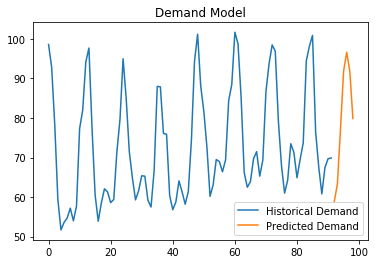

In [272]:
pred_demand = 1.7094*ng.loc[nan_selector,'edd']+44.8393
ng['demand'].plot(legend = True, title = 'Demand Model', label = 'Historical Demand')
pred_demand.plot(legend = True, label = 'Predicted Demand')

### Inventory Model

In [217]:
inv_X = sm.add_constant(ng_workable[['demand','edd','price']])
results = sm.OLS(ng_workable.inventory,inv_X).fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              inventory   R-squared:                       0.191
Model:                            OLS   Adj. R-squared:                  0.164
Method:                 Least Squares   F-statistic:                     6.947
Date:                Wed, 06 Oct 2021   Prob (F-statistic):           0.000300
Time:                        04:58:30   Log-Likelihood:                -734.72
No. Observations:                  92   AIC:                             1477.
Df Residuals:                      88   BIC:                             1488.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       2749.9148   1129.261      2.435      0.017     505.746    4994.084
demand        22.4484     21.377      1.050      0.297     -20.033      64.930
edd          -65.9992     38.973     -1.693      0.094    -143.450      11.452
price       -223.0132    107.326     -2.078      0.041    -436.302      -9.725
==============================================================================
Omnibus:                        9.294   Durbin-Watson:                   0.306
Prob(Omnibus):                  0.010   Jarque-Bera (JB):                3.495
Skew:                          -0.119   Prob(JB):                        0.174
Kurtosis:                       2.075   Cond. No.                     1.14e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.14e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [220]:
inv_X = sm.add_constant(ng_workable[['edd','price']])
results = sm.OLS(ng_workable.inventory,inv_X).fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              inventory   R-squared:                       0.181
Model:                            OLS   Adj. R-squared:                  0.163
Method:                 Least Squares   F-statistic:                     9.858
Date:                Wed, 06 Oct 2021   Prob (F-statistic):           0.000136
Time:                        05:02:45   Log-Likelihood:                -735.29
No. Observations:                  92   AIC:                             1477.
Df Residuals:                      89   BIC:                             1484.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       3893.8963    297.660     13.082      0.000    3302.452    4485.341
edd          -26.4387      9.993     -2.646      0.010     -46.294      -6.583
price       -277.0995     94.215     -2.941      0.004    -464.303     -89.896
==============================================================================
Omnibus:                       13.336   Durbin-Watson:                   0.315
Prob(Omnibus):                  0.001   Jarque-Bera (JB):                4.362
Skew:                          -0.177   Prob(JB):                        0.113
Kurtosis:                       1.994   Cond. No.                         74.3
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

$$Inventory = -26.4387EDD -277.0995Price + 3893.8963$$

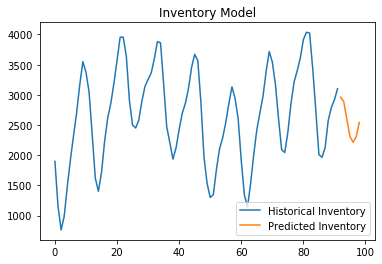

In [275]:
pred_inventory = -26.4387*ng.loc[nan_selector,'edd'] -277.0995*ng.loc[nan_selector,'price_added']+3893.8963
ng['inventory'].plot(legend = True, title = 'Inventory Model', label = 'Historical Inventory')
pred_inventory.plot(legend = True, label = 'Predicted Inventory')

### Price Model

In [225]:
p_X = sm.add_constant(ng_workable[['supply','edd']])
results = sm.OLS(ng_workable.price,p_X).fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.210
Model:                            OLS   Adj. R-squared:                  0.193
Method:                 Least Squares   F-statistic:                     11.85
Date:                Wed, 06 Oct 2021   Prob (F-statistic):           2.74e-05
Time:                        05:05:09   Log-Likelihood:                -101.77
No. Observations:                  92   AIC:                             209.5
Df Residuals:                      89   BIC:                             217.1
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          8.0466      1.280      6.285      0.000       5.503      10.590
supply        -0.0761      0.018     -4.344      0.000      -0.111      -0.041
edd            0.0242      0.010      2.418      0.018       0.004       0.044
==============================================================================
Omnibus:                        7.771   Durbin-Watson:                   0.463
Prob(Omnibus):                  0.021   Jarque-Bera (JB):                7.421
Skew:                           0.676   Prob(JB):                       0.0245
Kurtosis:                       3.328   Cond. No.                     1.23e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.23e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

$$Price = -0.0761Supply + 0.0242EDD + 8.0466$$

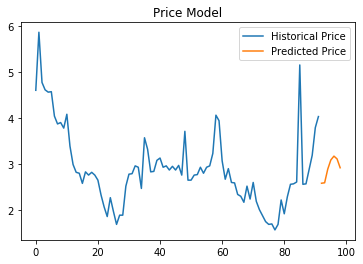

In [279]:
pred_price = -0.0761*ng.loc[nan_selector,'supply'] + 0.0242*ng.loc[nan_selector,'edd'] + 8.0466
ng['price'].plot(legend = True, title = 'Price Model', label = 'Historical Price')
pred_price.plot(legend = True, label = 'Predicted Price')

In [277]:
# Needed for Inventory Calculation
ng.loc[nan_selector,'price_added'] = -0.0761*ng.loc[nan_selector,'supply'] + 0.0242*ng.loc[nan_selector,'edd'] + 8.0466

In [ ]:
# Add values OPTIONAL
ng.loc[nan_selector,'demand'] = 1.7094*ng.loc[nan_selector,'edd']+44.8393
ng.loc[nan_selector,'demand']
ng.loc[nan_selector,'inventory'] = -26.4387*ng.loc[nan_selector,'edd'] -277.0995*ng.loc[nan_selector,'price']+3893.8963
ng.loc[nan_selector,'inventory']
ng.loc[nan_selector,'price_added'] = -0.0761*ng.loc[nan_selector,'supply'] + 0.0242*ng.loc[nan_selector,'edd'] + 8.0466
ng.loc[nan_selector,'price']

## b) SARIMA (Seasonal Auto Regressive Integrated Moving Average)

### Stationarity Tests (ADF)

In [387]:
def adf_test(series):
    result = adfuller(series)
    print('\n'+str.capitalize(series.name))
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))

In [388]:
pred_cols = ng_workable[['demand','inventory','price']]
for col in pred_cols:
    adf_test(ng_workable[col])


Demand
ADF Statistic: -0.988809
p-value: 0.757324
Critical Values:
	1%: -3.515
	5%: -2.898
	10%: -2.586

Inventory
ADF Statistic: -4.014202
p-value: 0.001338
Critical Values:
	1%: -3.516
	5%: -2.899
	10%: -2.587

Price
ADF Statistic: -3.552125
p-value: 0.006745
Critical Values:
	1%: -3.505
	5%: -2.894
	10%: -2.584


In [409]:
ng_workable.loc[:,'log_demand'] = np.log(ng_workable['demand'])
adf_test(ng_workable['log_demand'].dropna())

ng_workable.loc[:,'normalized_demand'] = ng_workable['demand'] - ng_workable['demand'].rolling(window = 4).mean()
ng_workable.loc[0:2,'normalized_demand'] = np.log(ng_workable['demand'])
adf_test(ng_workable['normalized_demand'])

#ng_workable['normalized_demand'].plot(legend = True, label = 'Predicted Normalized Demand')


Log_demand
ADF Statistic: -1.151686
p-value: 0.694027
Critical Values:
	1%: -3.515
	5%: -2.898
	10%: -2.586

Normalized_demand
ADF Statistic: -3.456921
p-value: 0.009165
Critical Values:
	1%: -3.515
	5%: -2.898
	10%: -2.586


### Normalized Demand Model

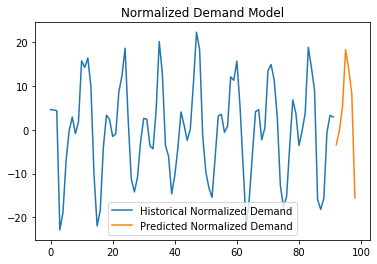

In [411]:
auto_arima(ng_workable['normalized_demand'], seasonal = True, m = 12, start_p = 0, start_q = 0, max_P = 5, max_D = 5, max_Q = 5).summary()
ng['normalized_demand'] = ng_workable['normalized_demand']
arima_model = SARIMAX(ng_workable['normalized_demand'], order = (0,0,1), seasonal_order = (1,1,[],12))
arima_result = arima_model.fit()
arima_result.summary()

sarima_pred = arima_result.predict(start = 92, end = 98)
ng['normalized_demand'].plot(legend = True, title = 'Normalized Demand Model', label = 'Historical Normalized Demand')
sarima_pred.plot(legend = True, label = 'Predicted Normalized Demand')

### Inventory Model

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


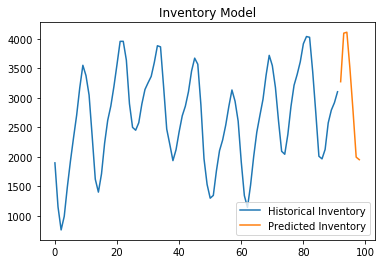

In [283]:
auto_arima(ng_workable['inventory'], seasonal = True, m = 12, start_p = 0, start_q = 0, max_P = 5, max_D = 5, max_Q = 5).summary()

arima_model = SARIMAX(ng_workable['inventory'], order = (0,0,1), seasonal_order = (1,1,[],12))
arima_result = arima_model.fit()
arima_result.summary()

sarima_pred = arima_result.predict(start = 92, end = 98)
ng['inventory'].plot(legend = True, title = 'Inventory Model', label = 'Historical Inventory')
sarima_pred.plot(legend = True, label = 'Predicted Inventory')

### Price Model

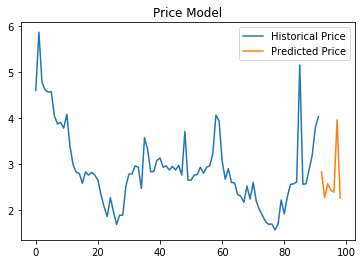

In [284]:
auto_arima(ng_workable['price'], seasonal = True, m = 12, start_p = 0, start_q = 0, max_P = 5, max_D = 5, max_Q = 5).summary()

arima_model = SARIMAX(ng_workable['price'], order = (0,0,1), seasonal_order = (1,1,[],12))
arima_result = arima_model.fit()
arima_result.summary()

sarima_pred = arima_result.predict(start = 92, end = 98)
ng['price'].plot(legend = True, title = 'Price Model', label = 'Historical Price')
sarima_pred.plot(legend = True, label = 'Predicted Price')


# Additional Notes

*Linear Regression:*

Pros:
- simple, replicable model
- applies intrinsic, atemporal relationships within data

Cons:
- linear relationships assumed by correl/OLS
- chain of dependent assumptions
- accuracy/smoothness

*SARIMA:*

Pros:
- Accounts for seasonality, non-linear trends
- accuracy/smoothness

Cons:

- Fit past data when past data is not usually indicative of future trends.